In [0]:
!pip install numpy
!pip install pandas

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np 
import pandas as pd 


#Loading the dataset
dataset = pd.read_csv('/content/drive/My Drive/syrusdataset.csv')

In [4]:
# Prin some samples
dataset.head(10)

,content,sentiment
0,tiffanylue i know i was listenin to bad habit...,neutral
1,Layin n bed with a headache ughhhh...waitin o...,sadness
2,Funeral ceremony...gloomy friday...,sadness
3,wants to hang out with friends SOON!,happiness
4,dannycastillo We want to trade with someone wh...,neutral
5,Re-pinging ghostridah14: why didn't you go to ...,worry
6,"I should be sleep, but im not! thinking about ...",sadness
7,Hmmm. http://www.djhero.com/ is down,worry
8,charviray Charlene my love. I miss you,sadness
9,kelcouch I'm sorry at least it's Friday?,sadness


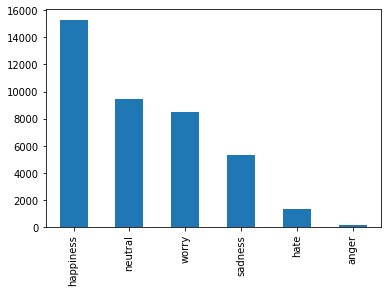

In [5]:
# Plot label histogram
dataset.sentiment.value_counts().plot.bar()

## Tokenisation

In [6]:
input_sentences = [text.split(" ") for text in dataset["content"].values.tolist()]
labels = dataset["sentiment"].values.tolist()
input_sentences

[['tiffanylue',
  'i',
  'know',
  '',
  'i',
  'was',
  'listenin',
  'to',
  'bad',
  'habit',
  'earlier',
  'and',
  'i',
  'started',
  'freakin',
  'at',
  'his',
  'part',
  '=['],
 ['Layin',
  'n',
  'bed',
  'with',
  'a',
  'headache',
  '',
  'ughhhh...waitin',
  'on',
  'your',
  'call...'],
 ['Funeral', 'ceremony...gloomy', 'friday...'],
 ['wants', 'to', 'hang', 'out', 'with', 'friends', 'SOON!'],
 ['dannycastillo',
  'We',
  'want',
  'to',
  'trade',
  'with',
  'someone',
  'who',
  'has',
  'Houston',
  'tickets,',
  'but',
  'no',
  'one',
  'will.'],
 ['Re-pinging',
  'ghostridah14:',
  'why',
  "didn't",
  'you',
  'go',
  'to',
  'prom?',
  'BC',
  'my',
  'bf',
  "didn't",
  'like',
  'my',
  'friends'],
 ['I',
  'should',
  'be',
  'sleep,',
  'but',
  'im',
  'not!',
  'thinking',
  'about',
  'an',
  'old',
  'friend',
  'who',
  'I',
  'want.',
  'but',
  "he's",
  'married',
  'now.',
  'damn,',
  '&amp;',
  'he',
  'wants',
  'me',
  '2!',
  'scandalous!'],


# Creating Vocabulary (word index)

In [7]:
# Initialize word2id and label2id dictionaries that will be used to encode words and labels
word2id = dict()
label2id = dict()

max_words = 0 # maximum number of words in a sentence

# Construction of word2id dict
for sentence in input_sentences:
    for word in sentence:
        # Add words to word2id dict if not exist
        if word not in word2id:
            word2id[word] = len(word2id)
    # If length of the sentence is greater than max_words, update max_words
    if len(sentence) > max_words:
        max_words = len(sentence)
    
# Construction of label2id and id2label dicts
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'neutral', 1: 'happiness', 2: 'hate', 3: 'anger', 4: 'sadness', 5: 'worry'}

# Encoding samples with corresponing integer values

In [11]:
import keras

# Encode input words and labels
X = [[word2id[word] for word in sentence] for sentence in input_sentences]
Y = [label2id[label] for label in labels]

# Apply Padding to X
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, max_words)

# Convert Y to numpy array
Y = keras.utils.to_categorical(Y, num_classes=len(label2id), dtype='float32')

# Print shapes
print("Shape of X: {}".format(X.shape))
print("Shape of Y: {}".format(Y.shape))


Shape of X: (40000, 101)
Shape of Y: (40000, 6)


# Build LSTM model with attention mechanism

In [12]:
embedding_dim = 100 # The dimension of word embeddings

# Define input tensor
sequence_input = keras.Input(shape=(max_words,), dtype='int32')

# Word embedding layer
embedded_inputs =keras.layers.Embedding(len(word2id) + 1,
                                        embedding_dim,
                                        input_length=max_words)(sequence_input)

# Apply dropout to prevent overfitting
embedded_inputs = keras.layers.Dropout(0.2)(embedded_inputs)

# Apply Bidirectional LSTM over embedded inputs
lstm_outs = keras.layers.wrappers.Bidirectional(
    keras.layers.LSTM(embedding_dim, return_sequences=True)
)(embedded_inputs)

# Apply dropout to LSTM outputs to prevent overfitting
lstm_outs = keras.layers.Dropout(0.2)(lstm_outs)

# Attention Mechanism - Generate attention vectors
input_dim = int(lstm_outs.shape[2])
permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
attention_vector = keras.layers.Reshape((max_words,))(attention_vector)
attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])

# Last layer: fully connected with softmax activation
fc = keras.layers.Dense(embedding_dim, activation='relu')(attention_output)
output = keras.layers.Dense(len(label2id), activation='softmax')(fc)

# Finally building model
model = keras.Model(inputs=[sequence_input], outputs=output)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

# Print model summary
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 101)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 101, 100)     8317100     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 101, 100)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 101, 200)     160800      dropout_3[0][0]                  
____________________________________________________________________________________________

# Training the model

In [14]:
# Train model for a few iterations
model.fit(X, Y, epochs=2, batch_size=64, validation_split=0.1, shuffle=True)

Train on 36000 samples, validate on 4000 samples
Epoch 1/2
36000/36000 [==============================] - 285s 8ms/step - loss: 0.6913 - acc: 0.7448 - val_loss: 1.3168 - val_acc: 0.5168
Epoch 2/2
36000/36000 [==============================] - 284s 8ms/step - loss: 0.3465 - acc: 0.8828 - val_loss: 1.5379 - val_acc: 0.5410


In [0]:
# Re-create the model to get attention vectors as well as label prediction
model_with_attentions = keras.Model(inputs=model.input,
                                    outputs=[model.output, 
                                             model.get_layer('attention_vec').output])

# Testing on a random sentence from the dataset itself and visualise the output

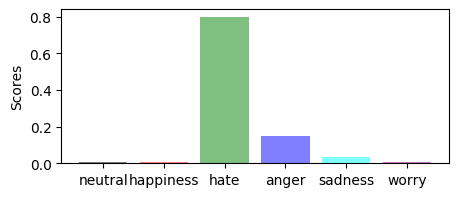

In [26]:
import random
import math

# Select random samples to illustrate
sample_text = random.choice(dataset["content"].values.tolist())

# Encode samples
tokenized_sample = sample_text.split(" ")
encoded_samples = [[word2id[word] for word in tokenized_sample]]

# Padding
encoded_samples = keras.preprocessing.sequence.pad_sequences(encoded_samples, maxlen=max_words)

# Make predictions
label_probs, attentions = model_with_attentions.predict(encoded_samples)
label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}

# Get word attentions using attenion vector
token_attention_dic = {}
max_score = 0.0
min_score = 0.0
for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
    token_attention_dic[token] = math.sqrt(attention_score)


# VISUALIZATION
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    color = rgb_to_hex((255, r, r))
    return str(color)
    
# Build HTML String to viualize attentions
html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
for token, attention in token_attention_dic.items():
    html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),
                                                                        token)
html_text += "</p>"
# Display text enriched with attention scores 
display(HTML(html_text))

# PLOT EMOTION SCORES
emotions = [label for label, _ in label_probs.items()]
scores = [score for _, score in label_probs.items()]
plt.figure(figsize=(5,2))
plt.bar(np.arange(len(emotions)), scores, align='center', alpha=0.5, color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
plt.xticks(np.arange(len(emotions)), emotions)
plt.ylabel('Scores')
plt.show()
